# An example of finite element method for 1D heat equation

A Jupyter Notebook with source code is located at [this](https://github.com/krashkov/Blog) GitHub repository.

**Contents**

* Classical and weak solutions of PDEs
* The basics of FEM
    * Galerkin approximations
    * Basis functions
    * Final system of equations
* Numerical example: 1D heat transfer problem
    * Analytical solution
    * Numerical solution with FEM

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt

---

## 1 Classical and weak solutions of PDEs

In this section an intuitive explanation of classical and weak solutions of elliptic second-order PDEs is given. However, for simplicity we will consider an ODE instead on an open bounded domain $\Omega$ with a mixed condition on the boundary $\partial \Omega$:

$$
\begin{align}
& - \frac{d}{dx} \left( k(x) \frac{du(x)}{dx} \right) + c(x) \frac{du(x)}{dx}
  + b(x) u(x) = f(x),\ x \in (0,1) \\
& \alpha_0 \frac{du(0)}{dx} + \beta_0 u(0) = \gamma_0\\
& \alpha_1 \frac{du(1)}{dx} + \beta_1 u(1) = \gamma_1\\
\end{align}
\tag{1}
$$

Roughly speaking, minimal smoothness solution of a PDE which satisfies both equations and boundary condition is called a *classical solution*. In other words, if a PDE contains $n$-th partial derivative, then this derivative must exist. A classical solution for a general linear strictly elliptic PDE is a function $u$ such that $u \in C^{2, \alpha} (\bar{\Omega})$, i.e. it is twice differentiable with $\alpha$*-Holder continuous* second-order derivatives [1].

However, many PDEs do not admit of sufficiently smooth solutions. Alternative description which allows to relax the assumptions is called a *weak formulation*. To derive a weak formulation of (1) let us test this equation against any sufficiently smooth function $\phi$ such that $\phi(x)|_{\partial \Omega} = 0$:

$$
- \int_0^1 \frac{d}{dx} \left( k \frac{du}{dx} \right) \phi dx
+ \int_0^1 c \frac{du}{dx} \phi dx
+ \int_0^1 b u \phi dx
= \int_0^1 f \phi dx
$$

Itegrating by parts the first term in the left-hand side of the equation gives the following relation:

$$
- ku'\phi|_0^1
+ \int_0^1 (ku'\phi' + c u' \phi + b u \phi ) dx
= \int_0^1 f \phi dx
$$

Note that now $u$ de facto is not required to have a second derivative at every single point. But in what class of functions to look for to find a suitable choice for $u$ and $\phi$ so that it will make sense? It turns out, that a *Sobolev space* $H^1$ would be a reasonable answer. For more information about space of solutions and test functions of second-order elleptic PDEs, please, refer to [1]. Thus a weak formulation of the problem (1) is as follows.

**Weak formulation**. Find $u \in H^1$ such that

$$
- ku'\phi|_0^1
+ \int_0^1 (ku'\phi' + c u' \phi + b u \phi ) dx
= \int_0^1 f \phi dx,\ 
\forall \phi \in H^1
\tag{2}
$$

A function $u \in H^1$ that satisfies (2) is called a *weak solution*.

In addition, in the new formulation of the problem it is also not required of $k(x)$ to be continuous since the existence of a second derivative is not implied. In order to obtain compatibility condition, let us assume that $k(x)$ is discontinuous at some $x=b$. The following holds:

$$
\begin{align}
0
&= - ku'\phi|_0^b + \int_0^b (ku'\phi' + c u' \phi + b u \phi - f \phi) dx
   - ku'\phi|_b^1 + \int_b^0 (ku'\phi' + c u' \phi + b u \phi - f \phi) dx\\
&= - ku'\phi|_{x=b-0} + ku'\phi|_{x=b+0}
\end{align}
$$

Since $\phi$ is arbitrary:

$$
ku'|_{x=b-0} = ku'|_{x=b+0}
\tag{3}
$$

Discontinuity of the second kind of $f$ leads to the same result (3), but discontinuity of the third kind result in a jump of a *flux* $W = -ku'$ at this point [2].

---

## 2 The basics of FEM

Finite element method is a numerical approach used to find an approximate solution of a weak formulation of PDEs or ODEs. Thus, it is possible to deal with poorly behaved functions which are quite common in practical applications.

However, a weak formulation of the problem does not seem to be any simpler since a space of possible solutions $u$ is supposed to be infinite-dimensional. So the question is: how to approximate a weak formulation in such a way that it will be well-posed?

### 2.1 Galerkin approximations

The idea behind approximation of a weak formulation is to replace an infinite-dimensional space of solution and test functions with a finite-dimensional subspace. Let us denote this subspace as $S^h \subset H^1$, $\dim S^h = n$, and select a convinient basis $\{\psi_0(x), \cdots, \psi_{n-1}(x)\}$ in $S^h$. Decomposition on the basis functions is as follows:

$$
\begin{align}
\phi_h(x) &= \sum_{i=0}^{n-1} \zeta_i \psi_i(x)\\
u_h(x)    &= \sum_{i=0}^{n-1} u_i \psi_i(x)
\end{align}
\tag{4}
$$

So the goal is to find a set of coefficients $(u_0, \cdots, u_{n-1})$ since they fully define a finite element approximation $u_h \in S^h$. Substitution of $u$ and $\phi$ in Eq. (2) with expressions in Eq. (4) gives:

$$
\sum_{i=0}^{n-1} \zeta_i \left[
  - k(1) u'(1)
  + k(0) u'(0)
  + \sum_{j=0}^{n-1} u_j \int_0^1 \left( k \psi_j' \psi_i' + c \psi_j' \psi_i + b  \psi_j \psi_i \right)dx
  - \int_0^1 f \psi_i dx 
\right] = 0\\
\sum_{i=0}^{n-1} \zeta_i \left[
    k(1) \frac{\gamma_1 - \beta_1 u(1)}{\alpha_1} \psi_i(1)
  - k(0) \frac{\gamma_0 - \beta_0 u(0)}{\alpha_0} \psi_i(0)
  + \sum_{j=0}^{n-1} K_{ij} u_j - F_i
\right] = 0
$$

where the following notation is utilised $K_{ij} = \int_0^1 \left( k \psi_j' \psi_i' + c \psi_j' \psi_i + b  \psi_j \psi_i \right)dx$ and $F_i = \int_0^1 f \psi_i dx$. $K$ is called *stiffness matrix* and $F$ is a *load vector*. Since $\zeta_i$ are arbitrary the following equation holds:

$$
  k(1) \frac{\gamma_1 - \beta_1 u(1)}{\alpha_1} \psi_i(1)
- k(0) \frac{\gamma_0 - \beta_0 u(0)}{\alpha_0} \psi_i(0)
+ \sum_{j=0}^{n-1} K_{ij} u_j
= F_i,\ \forall i \in \{0, \cdots, n-1\}
\tag{5}
$$

### 2.2 Basis functions

In fact, there are different ways to define basis functions. Here we will consider a concrete example and use it later for a numerical problem in section 3. Let us introduce a mesh $\mathcal{T}_h$:

$$
\mathcal{T}_h = \{x_i = ih,\ h = \frac{1}{n - 1},\ i \in \{0,\cdots, n-1\}\}
$$

Each element of length $h_k$ is called a *finite element*. Basis functions are defined over finite elements in such a way that $u_h(x_i) = u_i,\ \forall i$. Hence:

$$
u(0) = u_0,\ u(1) = u_{n-1}
\tag{6}
$$

Now let us introduce a set of basis functions on $[0,1]$ also known as "hats":

$$
\begin{align}
&\Phi(t) =
  \begin{cases}
    1 - |t|,\ &|t| \leq 1 \\ 0,\ &|t| > 1
  \end{cases}\\
&\psi_i(x) = 
  \Phi\left(\frac{x - x_i}{h}\right),\ \forall i \in \{0, \cdots, n-1\}
\end{align}
\tag{7}
$$

It is possible to verify that:

$$
\psi_j(x_i) = \delta_{ij}\ \Rightarrow\ u_h(x_i) = u_i
$$

### 2.3 Final system of equations

Taking into consideration all above mentioned, we get a system of $(n-1)$ linear equations with $(n-1)$ unknowns.

$$
\begin{align}
i = 0:          &\ - k_0 \frac{\beta_0 u_0}{\alpha_0} + \sum_{j=0}^{n-1} K_{0j} u_j 
                   = F_0 + k_0\frac{\gamma_0}{\alpha_0}\\
i\neq\{0, n-1\}:&\ \sum_{j=0}^{n-1} K_{ij} u_j = F_i\\
i = n-1:        &\ k_{n-1} \frac{\beta_1 u_{n-1}}{\alpha_1} + \sum_{j=0}^{n-1} K_{n-1,j} u_j
                   = F_{n-1} - k_{n-1}\frac{\gamma_1}{\alpha_1}\\
\end{align}
\tag{8}
$$

Each basis function (7) intersects only with $\psi_{i-1}, \psi_{i+1}$. Thus (8) is in fact tridiagonal system of linear equations:

$$
\begin{bmatrix}
K_{00} - \frac{k_0\beta_0}{\alpha_0} & K_{01} & 0      & \cdots & 0\\
K_{10} & K_{11} & K_{12} & \cdots & 0\\
0      & K_{21} & K_{22} & \cdots & 0\\
\cdots & \cdots & \cdots & \cdots & \cdots\\
0      & 0      & 0      & \cdots & K_{n-1,n-1} + \frac{k_{n-1}\beta_1}{\alpha_1}\\
\end{bmatrix}
\begin{bmatrix}
u_0\\
u_1\\
u_2\\
\cdots\\
u_{n-1}
\end{bmatrix}
= \begin{bmatrix}
F_0 + k_0\frac{\gamma_0}{\alpha_0}\\
F_1\\
F_2\\
\cdots\\
F_{n-1} - k_{n-1}\frac{\gamma_1}{\alpha_1}
\end{bmatrix}
\tag{9}
$$

---

## 3 Numerical example: 1D heat transfer problem

Consider the following heat equation:

$$
\begin{align}
& -\frac{d}{dx}\left(k\frac{du}{dx}\right) = f,\ x \in (0,1)\\
& u'(0) = 0,\ u(1) = \gamma_1
\end{align}
\tag{10}
$$

where $u$ represents temperature and $f$ is power distribution of heat sources inside the material. Also suppose that:

$$
f(x) =
\begin{cases}
f_1, &x < 0.5 \\ f_2, &x \geq 0.5
\end{cases}
\qquad
k(x) =
\begin{cases}
k_1, &x < 0.5 \\ k_2, &x \geq 0.5
\end{cases}
$$

In [2]:
def f(x):
    if (x < 0.5): return 2.
    else:         return 0.
    
def k(x):
    if (x < 0.5): return 0.01
    else:         return 0.04
    
gamma1 = 273.

x0 = 0.
x1 = 1.
n  = 5

mesh = np.linspace(x0, x1, n)

### 3.1 Analytical solution

On each domain $[0, 0.5)$ and $[0.5, 1]$ Eq. (10) is simply an ODE with constant coefficients. 

$$
\begin{align}
x < 0.5:&   \quad u(x) = c_1 + c_2 x - \frac{f_1 x^2}{2 k_1}\\
x \geq 0.5:&\quad u(x) = c_3 + c_4 x - \frac{f_2 x^2}{2 k_2}\\
\end{align}
$$

Since $u$ is de facto temperature, it should be continuous at $x = 0.5$, so apart from boundary conditions the following equations should be used to find unknown constants:

$$
\begin{align}
u(x)|_{x=0.5-0} &= u(x)|_{x=0.5+0}\\
k_1 u'(x)|_{x=0.5-0} &= k_2 u'(x)|_{x=0.5+0}
\end{align}
$$

One may obtain that:

$$
\begin{align}
c_1 &= \frac{f_1k_1+0.5f_2k_1+0.5f_1k_2+4.k_1k_2\gamma_1}{4k_1k_2},\ &c_2 &= 0,\\
c_3 &= \frac{f_1+2k_2\gamma_1}{2k_2},\ &c_4 &= -\frac{f_1-f_2}{2k_2}
\end{align}
$$

In [3]:
def exact_solver(x, f1, f2, k1, k2, gamma1):
    c1 =   (f1*k1 + 0.5*f2*k1 + 0.5*f1*k2 + 4.*k1*k2*gamma1)/(4.*k1*k2)
    c2 =   0.
    c3 =   (f1 + 2.*k2*gamma1)/(2.*k2)
    c4 = - (f1 - f2)/(2.*k2)
    
    if (x < 0.5): return c1 + c2*x - f1*x*x/(2.*k1)
    else:         return c3 + c4*x - f2*x*x/(2.*k2)

In [4]:
exact_solution = np.array([
    exact_solver(x, f(0), f(1), k(0), k(1), gamma1) for x in np.linspace(x0, x1, 10**3)
])

### 3.2 Numerical solution with FEM

As a basis we will use "hat" functions defined by (7).

In [5]:
def psi(x, i, mesh):
    h = mesh[1] - mesh[0]
    t = (x - mesh[i])/h
    if (abs(t) <= 1): return (1. - abs(t))
    else:             return 0.

def psi_prime(x, i, mesh):
    h = mesh[1] - mesh[0]
    t = (x - mesh[i])/h
    if (abs(t) <= 1.):
        if (t <= 0.): return  1./h
        else:         return -1./h
    else: return 0.

It is possible to simplify (9) even further using boundary conditions from (10). Since $u_{n-1} = \gamma_1$ there are only $n-2$ equations:

$$
\begin{bmatrix}
K_{00} & K_{01} & 0      & \cdots & 0\\
K_{10} & K_{11} & K_{12} & \cdots & 0\\
0      & K_{21} & K_{22} & \cdots & 0\\
\cdots & \cdots & \cdots & \cdots & \cdots\\
0      & 0      & 0      & \cdots & K_{n-2,n-2}\\
\end{bmatrix}
\begin{bmatrix}
u_0\\
u_1\\
u_2\\
\cdots\\
u_{n-2}
\end{bmatrix}
= \begin{bmatrix}
F_0\\
F_1\\
F_2\\
\cdots\\
F_{n-2} - K_{n-2,n-1}\gamma_1
\end{bmatrix}
$$

Certainly, this system should be solved with the tridiagonal matrix algorithm. However, in principle, different possibilities for $f$, $k$ as well as basis functions are possible, so here a general implementation is presents, i.e. each element of the stiffness matrix and load vector is constructed by integrating corresponding functions over finite elements.

In [6]:
def fem_solver(gamma1, f, k, x0, x1, n, mesh, psi, psi_prime, exact_solver):
    
    # Construct K
    stiffness_matrix = np.zeros(shape=(n-1,n-1))
    for i in range(n-1):
        for j in range(n-1):
            stiffness_matrix[i][j] = scipy.integrate.quad(
                lambda x: k(x)*psi_prime(x, i, mesh)*psi_prime(x, j, mesh),
                x0, x1, epsabs = 1e-4, limit=200, points = [mesh[i-1], mesh[i], mesh[i+1]]
            )[0]
        
    # Construct F
    load_vector = np.zeros(shape=(n-1))
    for i in range(n-1):
        load_vector[i] = scipy.integrate.quad(
            lambda x: f(x)*psi(x, i, mesh),
            x0, x1, epsabs = 1e-4, limit=200, points = [mesh[i-1], mesh[i], mesh[i+1]]
        )[0]
    load_vector[n-2] = load_vector[n-2] - gamma1 * scipy.integrate.quad(
        lambda x: k(x)*psi_prime(x, n-1, mesh)*psi_prime(x, n-2, mesh),
        x0, x1, epsabs = 1e-4, limit=200, points = [mesh[n-3], mesh[n-2], mesh[n-1]]
    )[0]
        
    # Solve linear system
    res = np.linalg.solve(stiffness_matrix, load_vector)
    res = np.append(res, gamma1)
    
    # Find exact solution for a given mesh
    exact_solution = np.array([exact_solver(x, f(0), f(1), k(0), k(1), gamma1) for x in mesh])
    
    return {'res': res, 'tol': np.linalg.norm(res - exact_solution)}

In [7]:
fem_solution = fem_solver(gamma1, f, k, x0, x1, n, mesh, psi, psi_prime, exact_solver)

Let us compare exact and numerical solutions.

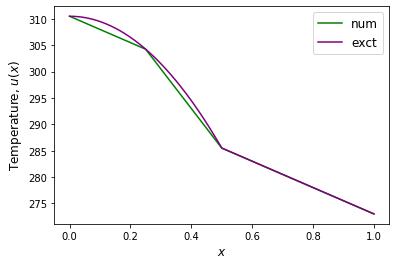

In [8]:
plt.figure(figsize=(6,4))
plt.plot(mesh, fem_solution['res'], label='num', color='green')
plt.plot(np.linspace(x0, x1, 10**3), exact_solution, label='exct', color = 'purple')
plt.xlabel(r"$x$", fontsize=12)
plt.ylabel(r"Temperature, $u(x)$", fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.show()

---

*References*

1. D. Gilbarg and N. Trudinger. Elliptic partial differential equations of second order, 1998
2. Finite Element Method Course Notes by T. LaForce, Stanford University, 2006 [[link](https://web.stanford.edu/class/energy281/FiniteElementMethod.pdf)]
3. A. Larcher and N. Degirmenci. Lecture Notes: The Finite Element Method, KTH Institute of Technology, 2013 [[link](https://www.kth.se/social/upload/5261b9c6f276543474835292/main.pdf)]
4. P. Arbenz. The Poisson Equation, ETH University [[link](http://people.inf.ethz.ch/arbenz/FEM17/pdfs/0-19-852868-X.pdf)]
5. M. Asadzadeh. An Introduction to the Finite Element Method (FEM) for Differential Equations, 2016 [[link](http://www.math.chalmers.se/~mohammad/teaching/PDEbok/draft_FEM_version6.pdf)]